### Objective of this notebook

Study the impact of the jump size on learning dynamics

For a fixed light profile and fixed measurement schedule, with particle diffusion taking place only after inference of a datapoint

In [1]:
import numpy as np
from cytoreactors.inference.BPI import Particles
import cytoreactors.modeling.EL222_model_2V_3P_A as model
from cytoreactors.modeling.simulation import simulate_analytic, light_profile_to_traj
import matplotlib.pyplot as plt
import matplotlib.cm as cm

We first build the light profile and the corresponding 'real' data

We measure every hour, for convenience the light profile is by 0.5 so that means we measure every 2 change of the profile

In [2]:
light_profile = sum([[(40,0.5),(40,0.5),(0,0.5),(0,0.5),(0,0.5)] for i in range(5)],[])
t_light,I_light = light_profile_to_traj(light_profile)

In [3]:
t_real, y_real, _ = simulate_analytic(model, model.default_model_pars, light_profile, [0,0], n_evals=30)
fp_real = y_real[-1,:]

In [4]:
sigma_measurement_noise = 15
t_measurements = np.arange(sum([d for _,d in light_profile])-1) + 1
fp_measurements = np.array([fp_real[np.argmax(t_real>t_measurement)-1] for t_measurement in t_measurements])
fp_measurements += np.random.normal(size=fp_measurements.shape, scale=sigma_measurement_noise)

In [5]:
def sample_unif_log(vmin,vmax):
    return vmin*np.exp(np.random.rand()*(np.log(vmax)-np.log(vmin)))

prior_bounds = {'sigma':(500,6000), 'deg_m':(0.8,5.0), 'deg_fp':(0.1,0.7)}

def simulate_inference_timecourse(jump_size):
    particles = Particles(n_particles=3000, model=model)
    # initial distribution as uniform in log space
    for ip in range(particles.n_particles):
        for p in particles.params:
            particles.params[p][ip] = sample_unif_log(prior_bounds[p][0],prior_bounds[p][1])
    # prepare structure to store data
    pars_traj = {p_name:np.empty((particles.n_particles, len(t_measurements)+1)) for p_name in particles.param_names}
    for p_name in pars_traj:
        pars_traj[p_name][:,0] = particles.params[p_name]
    # 
    for i_tp,tp in enumerate(t_measurements):
        particles.advance(light_profile[2*i_tp:2*i_tp+2])
        particles.treat_new_measurement(fp_measurements[i_tp], sigma_measurement_noise)
        particles.diffuse(jump_size)
        for p_name in pars_traj:
            pars_traj[p_name][:,i_tp+1] = particles.params[p_name]
    return pars_traj

In [6]:
results = {r:simulate_inference_timecourse(r) for r in [0.01, 0.03, 0.05, 0.5, 1.0]}

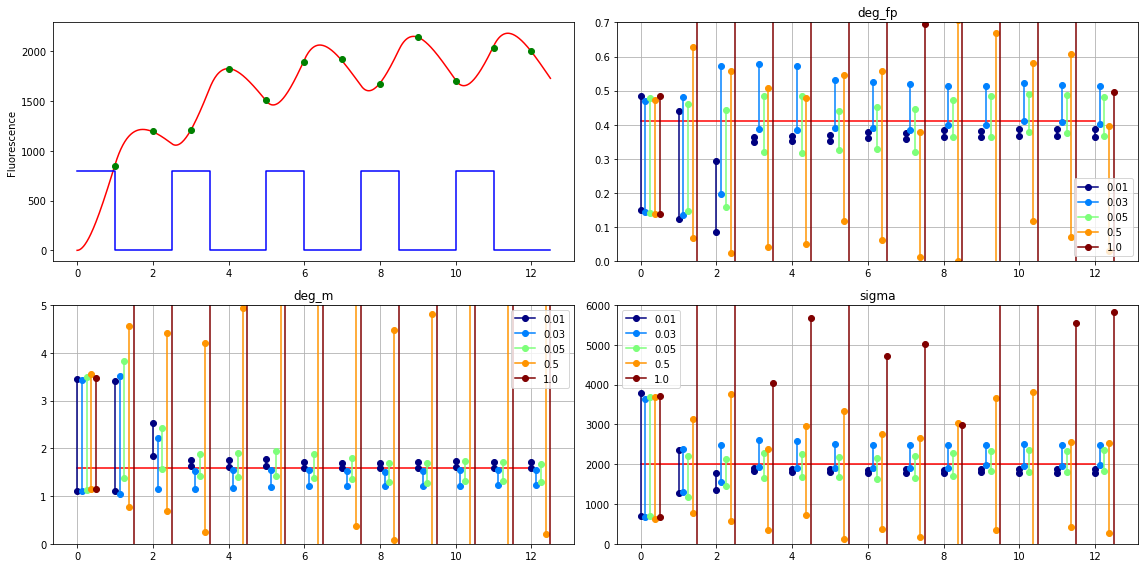

In [7]:
f,axs = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
axs = axs.ravel()
#
ax = axs[0]
ax.plot(t_real, fp_real, 'r')
ax.plot(t_light, I_light * 20, 'b')
ax.plot(t_measurements, fp_measurements, 'go')
ax.set_ylabel('Fluorescence')
for iparam,p in enumerate(['deg_fp', 'deg_m', 'sigma']):
    ax = axs[iparam+1]
    ax.plot([0,t_measurements[-1]],[model.default_model_pars[p],model.default_model_pars[p]],'r')
    for i,(jump_size,pars_traj) in enumerate(results.items()):
        color = cm.jet(np.linspace(0, 1, len(results)))[i]
        p_means = np.mean(pars_traj[p], axis=0)
        p_stds = np.std(pars_traj[p], axis=0)
        ax.plot([i/8,i/8],
                     [p_means[0]-p_stds[0],p_means[0]+p_stds[0]],
                     '-o',
                     color=color,
                     label=str(jump_size))
        for it,t_measurement in enumerate(t_measurements):
            ax.plot([t_measurement+i/8,t_measurement+i/8],
                     [p_means[it+1]-p_stds[it+1],p_means[it+1]+p_stds[it+1]],
                     '-o',
                     color=color)
        
    ax.set_ylim([0,prior_bounds[p][1]])
    ax.set_title(p)       
    ax.grid()
    ax.legend()
f.tight_layout()